# In-Database Image Classification using Xilinx FPGA


In [50]:
# Step 1: First import modules we use in this demo
import os,sys,cv2
from __future__ import print_function

from matplotlib import pyplot as plt
%matplotlib inline

In [51]:
# Connect to deepgreen
import dg.conn
from dg.admin import activity
con = dg.conn.Conn(user="nimbix", port=5432)
print (con.ver)

5


In [56]:
# We have setup xdrive to ls image files.   Let's see the files, 
xt = dg.xtable.fromQuery(con, '''
select dir, basename from 
imagefiles where basename like '%jpeg' or basename like '%jpg'
''')

xt5 = xt.select(where="dir like '%cat%'", samplerows=5)
print(xt5.sql)
print(xt5.show())

WITH tmp_5 as (
select dir, basename from 
imagefiles where basename like '%jpeg' or basename like '%jpg'
)
select * from tmp_5 where dir like '%cat%' limit sample 5 rows
+---------------------------------------------------------+----------------+
| dir                                                     | basename       |
|---------------------------------------------------------+----------------|
| /data/ftian/xdrive/images/101_ObjectCategories/wild_cat | image_0003.jpg |
| /data/ftian/xdrive/images/101_ObjectCategories/wild_cat | image_0020.jpg |
| /data/ftian/xdrive/images/101_ObjectCategories/wild_cat | image_0014.jpg |
| /data/ftian/xdrive/images/101_ObjectCategories/wild_cat | image_0027.jpg |
| /data/ftian/xdrive/images/101_ObjectCategories/wild_cat | image_0008.jpg |
+---------------------------------------------------------+----------------+


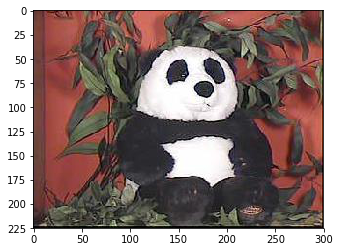

In [62]:
# Now, display a few images.
panda = cv2.imread("/data/ftian/xdrive/images/101_ObjectCategories/panda/image_0026.jpg")
panda = cv2.cvtColor(panda, cv2.COLOR_BGR2RGB)
plt.imshow(panda)
plt.show()

In [66]:
# Run a image recognition
gnet = dg.xtable.fromQuery(con, '''
select substr(filename, 54) as filename, nth, score, substr(tag, 0, 40) as tag from (
select 
dg_utils.transducer_column_text(1) as filename,
dg_utils.transducer_column_int4(2) as nth, 
dg_utils.transducer_column_float4(3) as score,
dg_utils.transducer_column_text(4) as tag,
gnet(), t.*
from (
    select dir || '/' || basename from imagefiles where 
    (basename like '%jpeg' or basename like '%jpg')
    and dir like '%panda%'
) t
) tmpt
''')


print(gnet.show(tablefmt='fancy_grid'))


╒════════════════╤═══════╤═════════════╤═════════════════════════════════════════╕
│ filename       │   nth │       score │ tag                                     │
╞════════════════╪═══════╪═════════════╪═════════════════════════════════════════╡
│ image_0017.jpg │     0 │ 0.897725    │ n02510455 giant panda, panda, panda bea │
├────────────────┼───────┼─────────────┼─────────────────────────────────────────┤
│ image_0017.jpg │     1 │ 0.0507243   │ n13044778 earthstar                     │
├────────────────┼───────┼─────────────┼─────────────────────────────────────────┤
│ image_0017.jpg │     2 │ 0.0110558   │ n02395406 hog, pig, grunter, squealer,  │
├────────────────┼───────┼─────────────┼─────────────────────────────────────────┤
│ image_0017.jpg │     3 │ 0.00478547  │ n04399382 teddy, teddy bear             │
├────────────────┼───────┼─────────────┼─────────────────────────────────────────┤
│ image_0017.jpg │     4 │ 0.00356934  │ n02132136 brown bear, bruin, Ursus arct │
├───

In [67]:
q1 = gnet.select(select='filename, nth, score, tag', where = "nth > 0 and tag like 'n02510455%'")
print (q1.show())

+----------------+-------+-------------+-----------------------------------------+
| filename       |   nth |       score | tag                                     |
|----------------+-------+-------------+-----------------------------------------|
| image_0023.jpg |     3 | 0.0607417   | n02510455 giant panda, panda, panda bea |
| image_0027.jpg |     1 | 0.177649    | n02510455 giant panda, panda, panda bea |
| image_0026.jpg |     3 | 0.000673773 | n02510455 giant panda, panda, panda bea |
| image_0029.jpg |     1 | 0.129704    | n02510455 giant panda, panda, panda bea |
| image_0025.jpg |     2 | 0.0049728   | n02510455 giant panda, panda, panda bea |
| image_0003.jpg |     2 | 0.0384766   | n02510455 giant panda, panda, panda bea |
| image_0028.jpg |     1 | 0.0027305   | n02510455 giant panda, panda, panda bea |
| image_0033.jpg |     2 | 0.172596    | n02510455 giant panda, panda, panda bea |
+----------------+-------+-------------+-----------------------------------------+


In [63]:
# Run a image recognition
gnet = dg.xtable.fromQuery(con, '''
select tag, count(*) as cnt from (
select 
dg_utils.transducer_column_text(1) as filename,
dg_utils.transducer_column_int4(2) as nth, 
dg_utils.transducer_column_float4(3) as score,
dg_utils.transducer_column_text(4) as tag,
gnet(), t.*
from (
    select dir || '/' || basename from imagefiles where 
    (basename like '%jpeg' or basename like '%jpg')
    and dir like '%panda%'
) t
) tmpt 
where nth = 0
group by tag
''')


print(gnet.show())

+-----------------------------------------------------------------------------+-------+
| tag                                                                         |   cnt |
|-----------------------------------------------------------------------------+-------|
| n04399382 teddy, teddy bear                                                 |     9 |
| n03724870 mask                                                              |     1 |
| n02443114 polecat, fitch, foulmart, foumart, Mustela putorius               |     1 |
| n03720891 maraca                                                            |     1 |
| n03476684 hair slide                                                        |     1 |
| n04254680 soccer ball                                                       |     1 |
| n02134418 sloth bear, Melursus ursinus, Ursus ursinus                       |     1 |
| n02096585 Boston bull, Boston terrier                                       |     1 |
| n03124043 cowboy boot         

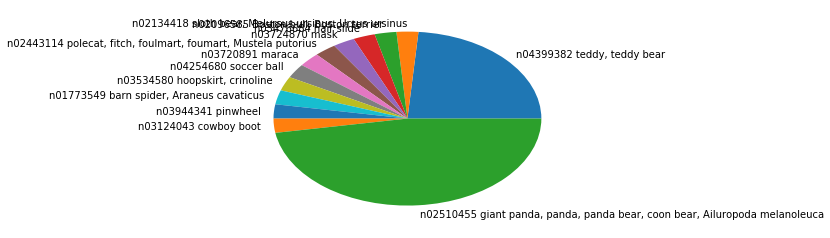

In [64]:
import dg.dsutil.plot
rows = gnet.execute()
pc = dg.dsutil.plot.PieChart(gnet.coldata('cnt', rows), labels=gnet.coldata('tag', rows))
pc.draw()